# Testing Graphs on Star Clusters

Using LightGraphs we test some graphs decomposition of the stellar cluster data

In [60]:
using PyCall
using Statistics , MultivariateStats
using Printf, Glob
using ImageFiltering
using Query, DataFrames, LightGraphs
using GraphPlot

import PyPlot , CSV , Distances
import Base.copy

sns= pyimport("seaborn")

rootdir = ENV["GAIA_ROOT"]
push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering

#Constants
const G= 4.30091e-3   #[solar mass][pc][km/s]

## directory
wdir    = "$rootdir/products"
plotdir = "$rootdir/products/test"
ocdir= "$wdir/oc2"

cd(wdir)

In [61]:
g = SimpleGraph()
add_vertex!(g)
add_vertices!(g,10)
add_edge!(g, 1 ,2)
add_edge!(g, 1 ,5)
add_edge!(g, 3 ,9)
add_edge!(g, 4,8)
add_edge!(g, 10,4)
add_edge!(g, 10,4)
add_edge!(g, 8,2)
add_edge!(g, 8,3)
add_edge!(g, 2,3)
nodelabel = collect(1:nv(g))
print(nodelabel)

gplot(g, nodelabel=nodelabel)

println(maximal_cliques(g))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]Array{Int64,1}[[2, 3, 8], [2, 1], [11], [7], [9, 3], [10, 4], [6], [4, 8], [5, 1]]


In [62]:
ocname= "NGC 2168-4.9deg-oc-mass.csv"
#ocname= "NGC 2516-3.5deg-oc-mass.csv"

oc= CSV.read("$ocdir/$ocname", delim= ";")

,ra,dec,l,b,distance,pmra,pmdec,X,Y
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,92.2248,23.8262,187.035,1.94584,885.142,2.04321,-2.90901,885.112,6.31771
2,92.1316,23.8472,186.975,1.88141,883.697,2.31571,-2.62221,883.669,5.38737
3,92.2162,23.8454,187.014,1.94822,884.354,2.10156,-2.64699,884.326,5.99305
4,92.2634,23.8036,187.072,1.96579,881.651,2.51005,-2.99476,881.618,6.86018
5,92.3031,23.9659,186.947,2.07603,876.595,2.60422,-3.03084,876.579,4.91368
6,92.456,24.2631,186.754,2.34174,855.55,2.61997,-2.81589,855.544,1.91357
7,92.1906,23.9769,186.888,1.99137,876.251,2.23847,-2.84031,876.237,4.00443
8,92.495,24.2453,186.787,2.36434,918.013,2.28728,-2.89032,918.005,2.57788
9,92.5054,24.2286,186.806,2.36452,879.507,2.21415,-2.56623,879.498,2.76432


In [63]:
## functions

function create_graph_XV(oc, dmax, vmax)
    g = SimpleGraph()
    ndata= length(oc.ra)
    add_vertices!(g,ndata)
    
    A= Array{Float64}(undef,2,ndata)
    B= Array{Float64}(undef,2,ndata)
    for i in 1:ndata
        A[:,i]= [oc.Y[i] oc.Z[i]]
        B[:,i]= [oc.vl[i] oc.vb[i]]
    end

    d= Distances.Euclidean()
    Ax= Distances.pairwise(d, A, A, dims=2)
    Av=  Distances.pairwise(d, B, B, dims=2)
     
    for i in 1:ndata
        for j in 1:i-1
            if Ax[i,j] <= dmax && Av[i,j] <= vmax && i != j
                add_edge!(g, i,j)
            end
        end
    end
    
    return(g)
end

create_graph_XV (generic function with 1 method)

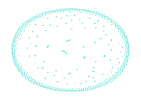

In [64]:
### MAIN
g= create_graph_XV(oc,0.5,0.5)
gplot(g)



In [65]:
# print(maximal_cliques(g))

for cl in maximal_cliques(g)
    if length(cl) > 2
        println(cl)
    end
end

t= connected_components(g)

[66, 185, 196]
[309, 281, 230]
[368, 369, 793]
[161, 139, 141]
[562, 541, 543]
[555, 344, 448]
[344, 448, 518]
[452, 206, 121]
[324, 129, 725]
[199, 124, 288]
[431, 767, 457]
[140, 228, 231]


750-element Array{Array{Int64,1},1}:
 [1]         
 [2]         
 [3]         
 [4]         
 [5]         
 [6]         
 [7]         
 [8, 18]     
 [9]         
 [10]        
 [11]        
 [12, 63]    
 [13, 48, 52]
 ⋮           
 [851]       
 [852]       
 [853]       
 [854]       
 [855]       
 [856]       
 [857]       
 [858]       
 [859]       
 [860]       
 [861]       
 [862]       

In [66]:
nbin= 20
clmat= zeros(Float64, nbin, nbin)

dx= 1.0 / nbin ; dy= 1.0 / nbin
for i in 1:nbin
    for j in 1:nbin
        dm= dx*i
        dv= dy*j
        
        gi= create_graph_XV(oc,dm,dv)
        cli= maximal_cliques(gi)
        ccon= connected_components(gi)
        ncli= 0 ; nccon= 0
        for cl in cli
            if length(cl) > 2  ncli +=1 end
        end 
        for con in ccon
            if length(con) > 2  nccon +=1 end
        end
        
        if nccon==0 nccon=1 end
        clmat[i,j]= ncli/nccon
    end
end

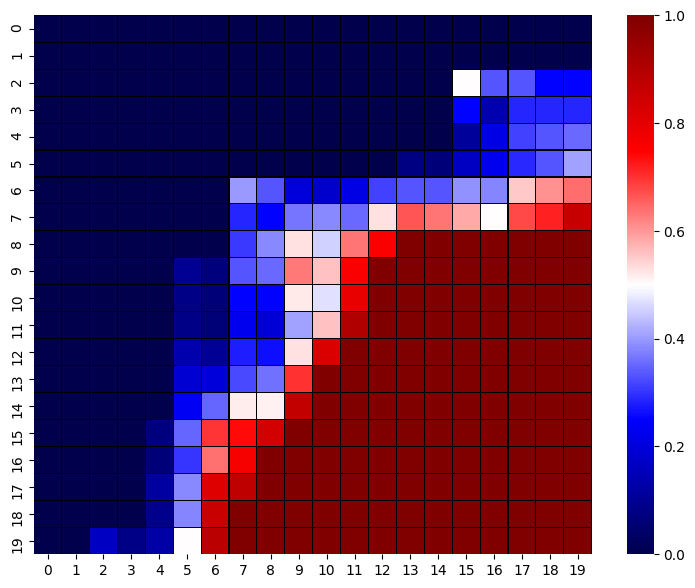

[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.5 0.3333333333333333 0.3333333333333333 0.25 0.25; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.25 0.14285714285714285 0.2857142857142857 0.2857142857142857 0.2857142857142857; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1111111111111111 0.21428571428571427 0.3125 0.3333333333333333 0.35294117647058826; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.07692307692307693 0.0625 0.16666666666666666 0.22727272727272727 0.2916666666666667 0.3333333333333333 0.4074074074074074; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.4 0.3333333333333333 0.2 0.18181818181818182 0.21428571428571427 0.3125 0.3333333333333333 0.3333333333333333 0.391304347826087 0.3793103448275862 0.5517241379310345 0.6060606060606061 0.6410256410256411; 0.0 0.0 0.0 0.0 0.0 0.0

In [68]:
fig= PyPlot.figure(figsize=(9,7))
heat_map = sns.heatmap(clmat, vmin=0, vmax=1, cmap= "seismic",linewidths=0.1, 
    linecolor="black")
PyPlot.show()
